**References:** 

1. [DEAP: A Database for Emotion Analysis using Physiological Signals](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/doc/tac_special_issue_2011.pdf)

2. [Online Prediction of Driver Distraction Based on Brain Activity Patterns](https://www.researchgate.net/publication/267154789_Online_Prediction_of_Driver_Distraction_Based_on_Brain_Activity_Patterns)

3. [Emotion Recognition with Machine Learning Using
EEG Signals](https://arxiv.org/pdf/1903.07272.pdf)

4. [EEG Correlates of Different Emotional States Elicited during Watching Music Videos](https://www.researchgate.net/publication/221622214_EEG_Correlates_of_Different_Emotional_States_Elicited_during_Watching_Music_Videos)

5. [The Effect of Transcranial Magnetic Stimulation on Brain Electrical Activity](https://www.researchgate.net/publication/267811728_THE_EFFECT_OF_TRANSCRANIAL_MAGNETIC_STIMULATION_ON_BRAIN_BIOELECTRICAL_ACTIVITY)

**Original dataset:** 

The dataset is mounted from our Google Drive and could be downloaded [here](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/download.html). 

In [3]:
import os
import time
import pickle
import pandas as pd
import numpy as np
import pywt

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

from sklearn.decomposition import FastICA

import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

In [34]:
root_folder = 'C:/Users/thiag/OneDrive - Georgia Institute of Technology/DEAP'


npy_folder = os.path.join(os.getcwd(), 'results', 'npy')
feats_folder = os.path.join(os.getcwd(), 'results', 'EEG_features')


if not os.path.exists(feats_folder):
    os.makedirs(feats_folder, exist_ok=True)

# Load dataset
The EEG and peripheral physiological signals of 32 participants were recorded as each watched 40 music videos. Participants rated each video in terms of the levels of arousal, valence, dominance, and liking. The data was downsampled (to 128Hz), preprocessed and segmented in pickled Python formats.

In [4]:
# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [5]:
# Load only 22/32 participants with frontal videos recorded
files = []
for n in range(1, 23): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
print(files)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']


Each participant file contains two arrays: a "data" array (40 trials x 40 channels x 8064 data) and a "label" array (40 trials x 4 subjective ratings: valence, arousal, dominance, liking). We combine the data files into 2 new arrays with 880 trials for 22/32 participants (participants with frontal videos recorded).

In [6]:
# 22x40 = 880 trials for 22 participants
labels = []
data = []

for i in files: 
  filename = "C:/Users/thiag/OneDrive - Georgia Institute of Technology/DEAP/data_preprocessed_python/s" + i + ".dat"
  trial = read_eeg_signal_from_file(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])
   
    
# Re-shape arrays into desired shapes
labels = np.array(labels)
print("Labels - previous: ", labels.shape) # trial x label
labels = labels.flatten()
labels = labels.reshape(880, 4)

data = np.array(data)
print("Data - previous: ", data.shape) # trial x channel x data   
data = data.flatten()
data = data.reshape(880, 40, 8064)

Labels - previous:  (22, 40, 4)
Data - previous:  (22, 40, 40, 8064)


In [7]:
# Double-check the new arrays
print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (880, 4)
Data:  (880, 40, 8064)


# Explore and pre-process data

## Labels

#### Get Valence and Arousal ratings
Valence describes the extent to which an emotion is positive or negative, whereas Arousal refers to its intensity, i.e., the strength of the associated emotional state.

In [8]:
# Only extract Valence and Arousal ratings
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})
print(df_label_ratings.describe())

          Valence     Arousal
count  880.000000  880.000000
mean     5.218034    5.238898
std      2.093837    1.879631
min      1.000000    1.000000
25%      3.650000    3.895000
50%      5.040000    5.490000
75%      7.040000    6.795000
max      9.000000    9.000000


In [9]:
print(df_label_ratings.head(15))

    Valence  Arousal
0      7.71     7.60
1      8.10     7.31
2      8.58     7.54
3      4.94     6.01
4      6.96     3.92
5      8.27     3.92
6      7.44     3.73
7      7.32     2.55
8      4.04     3.29
9      1.99     4.86
10     2.99     2.36
11     2.71     2.77
12     1.95     3.12
13     4.18     2.24
14     3.17     8.08


<AxesSubplot:>

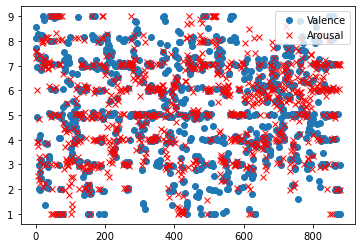

In [10]:
# Plot the first 40 data rows (first participant)
df_label_ratings.iloc[0:880].plot(style=['o','rx'])

#### Check positive/negative cases

The combinations of Valence and Arousal can be converted to emotional states: High Arousal Positive Valence (Excited, Happy), Low Arousal Positive Valence (Calm, Relaxed), High Arousal Negative Valence (Angry, Nervous), and Low Arousal Negative Valence (Sad, Bored).

In [11]:
# High Arousal Positive Valence dataset
df_hahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Positive Valence dataset
df_lahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
# High Arousal Negative Valence dataset
df_halv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Negative Valence dataset
df_lalv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]

In [12]:
# Check nummber of trials per each group
print("Positive Valence:", str(len(df_hahv) + len(df_lahv)))
print("Negative Valence:", str(len(df_halv) + len(df_lalv)))
print("High Arousal:", str(len(df_hahv) + len(df_halv)))
print("Low Arousal:", str(len(df_lahv) + len(df_lalv)))

Positive Valence: 457
Negative Valence: 423
High Arousal: 442
Low Arousal: 438


In [13]:
# Check nummber of trials per each group
print("High Arousal Positive Valence:", str(len(df_hahv)))
print("Low Arousal Positive Valence:", str(len(df_lahv)))
print("High Arousal Negative Valence:", str(len(df_halv)))
print("Low Arousal Negative Valence:", str(len(df_lalv)))

High Arousal Positive Valence: 242
Low Arousal Positive Valence: 215
High Arousal Negative Valence: 200
Low Arousal Negative Valence: 223


In [14]:
# Get mean and std of each group
print("HAHV")
print("Valence:", "Mean", np.round(df_hahv['Valence'].mean(),2), "STD", np.round(df_hahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_hahv['Arousal'].mean(),2), "STD", np.round(df_hahv['Arousal'].std(),2))
print()
print("LAHV:")
print("Valence:", "Mean", np.round(df_lahv['Valence'].mean(),2), "STD", np.round(df_lahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lahv['Arousal'].mean(),2), "STD", np.round(df_lahv['Arousal'].std(),2))
print()
print("HALV:")
print("Valence:", "Mean", np.round(df_halv['Valence'].mean(),2), "STD", np.round(df_halv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_halv['Arousal'].mean(),2), "STD", np.round(df_halv['Arousal'].std(),2))
print()
print("LALV:")
print("Valence:", "Mean", np.round(df_lalv['Valence'].mean(),2), "STD", np.round(df_lalv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lalv['Arousal'].mean(),2), "STD", np.round(df_lalv['Arousal'].std(),2))

HAHV
Valence: Mean 7.12 STD 1.04
Arousal: Mean 6.81 STD 0.84

LAHV:
Valence: Mean 6.67 STD 1.09
Arousal: Mean 3.87 STD 1.09

HALV:
Valence: Mean 3.19 STD 1.23
Arousal: Mean 6.79 STD 0.96

LALV:
Valence: Mean 3.57 STD 1.12
Arousal: Mean 3.47 STD 1.19


{'whiskers': [<matplotlib.lines.Line2D at 0x27180933c40>,
 'caps': [<matplotlib.lines.Line2D at 0x2718093e3a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x271809338b0>,
 'medians': [<matplotlib.lines.Line2D at 0x2718093eac0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2718093ee50>,
 'means': []}

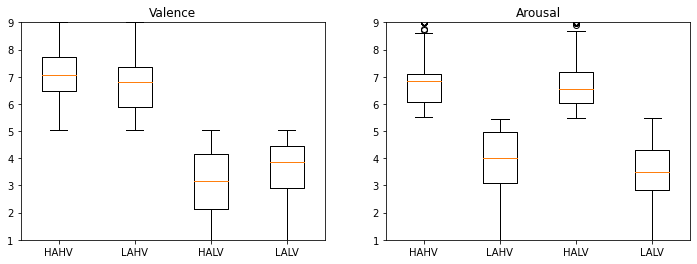

In [15]:
# Valence and Arousal ratings between groups
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].set_title("Valence")
axs[0].set_ylim(1, 9)
axs[0].boxplot([df_hahv['Valence'], df_lahv['Valence'], df_halv['Valence'], df_lalv['Valence']], labels=['HAHV','LAHV','HALV', 'LALV'])

axs[1].set_title("Arousal")
axs[1].set_ylim(1, 9)
axs[1].boxplot([df_hahv['Arousal'], df_lahv['Arousal'], df_halv['Arousal'], df_lalv['Arousal']], labels=['HAHV','LAHV','HALV', 'LALV'])

{'whiskers': [<matplotlib.lines.Line2D at 0x19580f9d6d0>,
 'caps': [<matplotlib.lines.Line2D at 0x19580f9ddf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x19580f9d340>,
 'medians': [<matplotlib.lines.Line2D at 0x19580fac550>,
 'fliers': [<matplotlib.lines.Line2D at 0x19580fac8e0>,
 'means': []}

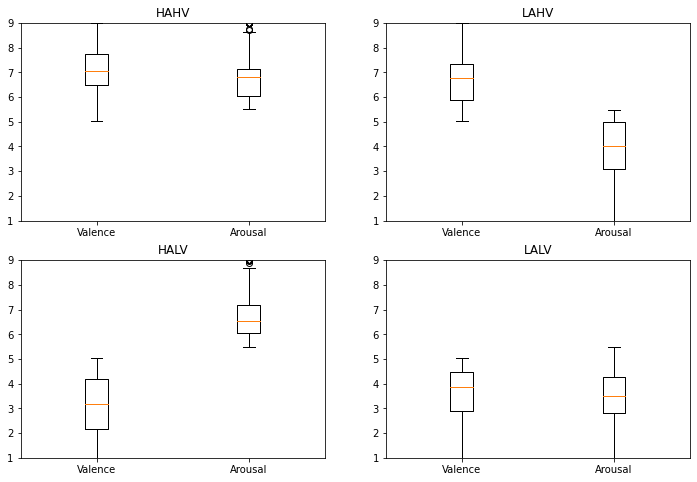

In [25]:
# Valence and Arousal ratings per group
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].set_title("HAHV")
axs[0,0].set_ylim(1, 9)
axs[0,0].boxplot([df_hahv['Valence'], df_hahv['Arousal']], labels=['Valence','Arousal'])

axs[0,1].set_title("LAHV")
axs[0,1].set_ylim(1, 9)
axs[0,1].boxplot([df_lahv['Valence'], df_lahv['Arousal']], labels=['Valence','Arousal'])

axs[1,0].set_title("HALV")
axs[1,0].set_ylim(1, 9)
axs[1,0].boxplot([df_halv['Valence'], df_halv['Arousal']], labels=['Valence','Arousal'])

axs[1,1].set_title("LALV")
axs[1,1].set_ylim(1, 9)
axs[1,1].boxplot([df_lalv['Valence'], df_lalv['Arousal']], labels=['Valence','Arousal'])

#### One hot encoding

In [26]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0 
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [27]:
# Convert all ratings to boolean values
labels_encoded = []
for i in range (len(labels)):
  labels_encoded.append([positive_valence(i), high_arousal(i)])
labels_encoded = np.reshape(labels_encoded, (880, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["Positive Valence", "High Arousal"])
print(df_labels.describe())

       Positive Valence  High Arousal
count        880.000000    880.000000
mean           0.519318      0.502273
std            0.499911      0.500279
min            0.000000      0.000000
25%            0.000000      0.000000
50%            1.000000      1.000000
75%            1.000000      1.000000
max            1.000000      1.000000


In [28]:
# Dataset with only Valence column
df_valence = df_labels['Positive Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']

## EEG data

### Separate EEG and non-EEG data

The dataset includes 32 EEG channels and 8 peripheral physiological channels. The peripheral signals include: electrooculogram (EOG), electromyograms (EMG) of Zygomaticus and Trapezius muscles, GSR, respiration amplitude, blood volume by plethysmograph, skin temperature.

In [16]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [17]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(880, 32, 8064)


In [83]:
# Compute ICA
n_ICs = 32
ica = FastICA(n_components=n_ICs, max_iter=100)

In [84]:
eeg_ic = np.ndarray((eeg_data.shape[0],n_ICs,eeg_data.shape[2]))
for idx, epoch in enumerate(eeg_data):
    print(idx)
    ic = ica.fit_transform(epoch.T)
    eeg_ic[idx] = ic.T 
print(eeg_ic.shape)

0


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


1


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


2


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


3


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


4


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


5


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


6


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


7


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


8


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


9


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


10


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


11


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


12


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


13


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


14


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


15


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


16


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


17


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


18


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


19


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


20


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


21


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


22


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


23


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


24


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


25


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


26


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


27


c:\Users\thiag\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


28


KeyboardInterrupt: 

# Calculate energy of frequency bands using Discrete Wavelet Transform

In [85]:
def wavelet_entropy(eeg_data):
    wavelet = 'db6'
    level = 5
    waveletEnergy = np.ndarray((eeg_data.shape[0], eeg_data.shape[1], level+1))
    coeffs = pywt.wavedec(eeg_data, 'db6', level=5)
    cA5, cD5, cD4, cD3, cD2, cD1 = coeffs
    for idx, band in enumerate(coeffs):
        waveletEnergy[:,:,idx] = np.sum(np.power(band,2),-1)
    waveletTotEnergy = np.sum(energy,-1)
    normWaveletEnergy = (waveletEnergy.T/waveletTotEnergy.T).T
    waveletEntropy = (-1*normWaveletEnergy.T*np.log(normWaveletEnergy.T)).T

    return waveletEntropy


In [87]:
waveletEntropy = wavelet_entropy(eeg_data)
print(waveletEntropy.shape)

(880, 32, 6)


# Connectivity feature

In [28]:
iter_freqs = ((0.5, 3.5),   # Delta
              (3.5, 7),     # Theta
              (7, 14),      # Alpha    
              (14, 28),     # Beta
              (28, 56))     # Gamma
N_bands = len(iter_freqs)
N_EEG_electrodes = 32
sfreq = 128
n_epoch = eeg_data.shape[0]

(0.5, 3.5)


In [29]:
def calc_bands(epoch, iter_freqs, sfreq):
    freq_bands = np.ndarray((len(iter_freqs), epoch.shape[0], epoch.shape[1]))
    for idx, freq in enumerate(iter_freqs):
        filtered = mne.filter.filter_data(epoch, sfreq, freq[0], freq[1], verbose=False)
        freq_bands[idx] = filtered
    return freq_bands

In [30]:
def extract_phase(array):
    analytic_signal = signal.hilbert(array)
    instantaneous_phase = (np.angle(analytic_signal))
    phase = np.where(instantaneous_phase > 0, 1, -1)
    return instantaneous_phase/np.pi, phase

In [31]:
def PLV(data_1, data_2):
    instant_phase_1, phase_1 = extract_phase(data_1)
    instant_phase_2, phase_2 = extract_phase(data_2)
    inst_phase_sum = instant_phase_1 - instant_phase_2
    PLV = (np.exp(1j*inst_phase_sum))
    return np.abs(np.mean(PLV))

In [32]:
def epoch_connectivity(epoch):
    epoch_band_connectivity = np.ones((N_EEG_electrodes,N_EEG_electrodes))
    epoch_connectivity = np.ndarray((len(iter_freqs), N_EEG_electrodes, N_EEG_electrodes))
    epoch_bands = calc_bands(epoch, iter_freqs, sfreq)
    for idx_band, band in enumerate (epoch_bands):
        for ch_i in range (0,len(band)):
            for ch_j in range (0,len(band)):
                    # checking if i and j indexes are not on same element
                    if (ch_i!=ch_j):
                        if (ch_i>ch_j):
                            epoch_band_connectivity[ch_i][ch_j] = epoch_band_connectivity[ch_j][ch_i]
                        else:
                            epoch_band_connectivity[ch_i][ch_j] = PLV(band[ch_i,:], band[ch_j,:])
        epoch_connectivity[idx_band] = epoch_band_connectivity
    return epoch_connectivity

In [33]:
data_connectivity = np.ndarray((n_epoch, len(iter_freqs), N_EEG_electrodes, N_EEG_electrodes))

# epoch = eeg_data[0]
for idx_epoch, epoch in enumerate(eeg_data):
    print(idx_epoch)
    data_connectivity[idx_epoch,:,:,:] = epoch_connectivity(epoch)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

C:\Users\thiag\AppData\Local\Temp/ipykernel_15168/2417683405.py:3: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  pixel_plot.add_axes()


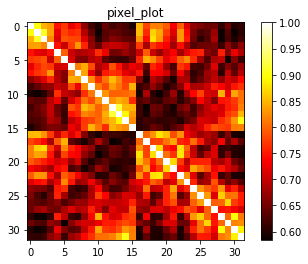

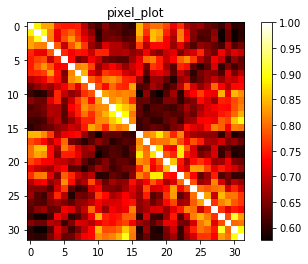

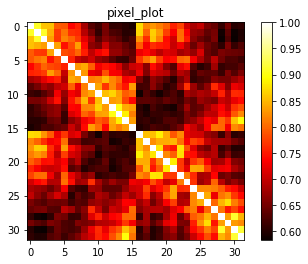

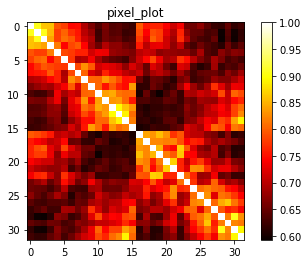

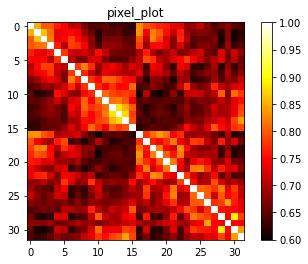

In [79]:
epoch_connectivity = data_connectivity[0]
for connectivity_matrix in epoch_connectivity:
    pixel_plot = plt.figure()
    pixel_plot.add_axes()
    plt.title("pixel_plot")
    pixel_plot = plt.imshow(connectivity_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar(pixel_plot)
    plt.show(pixel_plot)

In [89]:
feats_path = os.path.join(feats_folder, 'EEG_features.npy')

features = {}

features['connectivity'] = data_connectivity
features['waveletEntropy'] = waveletEntropy

np.save(feats_path, features)